#**ECE 421 ASSIGNMENT 2** 
By Valentina Manferrari

Student ID: 1004796615

Link to the Google Colab document: https://colab.research.google.com/drive/1jWGO4xT2RZAju4jPHbRAkNKCVlA3Xee8?usp=sharing



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%shell
jupyter nbconvert --to html /content/drive/MyDrive/ECE421/A2/ECE421_A2_code_manferrari.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/ECE421/A2/ECE421_A2_code_manferrari.ipynb to html
[NbConvertApp] Writing 359708 bytes to /content/drive/MyDrive/ECE421/A2/ECE421_A2_code_manferrari.html


# 1. Neural Networks using Numpy

In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [22]:
# Load the data
def loadData():
    with np.load("notMNIST.npz") as data:
        Data, Target = data["images"], data["labels"]
        np.random.seed(521)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data = Data[randIndx] / 255.0
        Target = Target[randIndx]
        trainData, trainTarget = Data[:10000], Target[:10000]
        validData, validTarget = Data[10000:16000], Target[10000:16000]
        testData, testTarget = Data[16000:], Target[16000:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

# Implementation of a neural network using only Numpy - trained using gradient descent with momentum
def convertOneHot(trainTarget, validTarget, testTarget):
    newtrain = np.zeros((trainTarget.shape[0], 10))
    newvalid = np.zeros((validTarget.shape[0], 10))
    newtest = np.zeros((testTarget.shape[0], 10))

    for item in range(0, trainTarget.shape[0]):
        newtrain[item][trainTarget[item]] = 1
    for item in range(0, validTarget.shape[0]):
        newvalid[item][validTarget[item]] = 1
    for item in range(0, testTarget.shape[0]):
        newtest[item][testTarget[item]] = 1
    return newtrain, newvalid, newtest

def shuffle(trainData, trainTarget):
    np.random.seed(421)
    randIndx = np.arange(len(trainData))
    target = trainTarget
    np.random.shuffle(randIndx)
    data, target = trainData[randIndx], target[randIndx]
    return data, target

### 1.1 Helper Functions

In [23]:
# This function accepts one argument and return a Numpy array wuth the ReLU activation
def relu(x):
    relu_x = np.copy(x)
    relu_x = relu_x.clip(min=0)
    return relu_x

In [24]:
# This function accepts one argument and return a Numpy array with the softmax activation
def softmax(x):
    softmax_x = np.exp(x)/np.sum(np.exp(x), axis=1, keepdims=True)
    return softmax_x

In [25]:
# This function accepts 3 arguments: an input vector, a weight marix and a bias vector
# Returns the product between the weights and input plus the biases i.e. a prediction for a given layer
def compute(X, W, b):
    compute_layer = np.matmul(X, W) + b  
    return compute_layer

In [26]:
# This function accepts two arguments: the targets (labels) and predictions
# Returns the average cross entropy loss for the dataset 
def averageCE(target, prediction):
    ce = -(1/prediction.shape[0]) * np.sum(target * np.log(prediction))
    return ce

In [27]:
# This function accepts two arguments: the targets (labels) and the input to the softmax function
# Returns the gradient of the cross entropy loss wrt the inputs of the softmax function
def gradCE(target, prediction):
    grad = -(1/prediction.shape[0]) * target / prediction
    return grad

### 1.3 Learning

In [66]:
def forward_propagation(dataIN, W, b):
    X, S = [None]*3, [None]*3
    X[0] = dataIN
    # updating hidden layer
    S[1] = np.matmul(X[0], W[1]) + b[1]
    X[1] = relu(S[1])
    # updating output layer
    S[2] = np.matmul(X[1], W[2]) + b[2]
    X[2] = softmax(S[2])
    return X, S

def backpropagation(X, S, W, label):
    delta = [None]*3
    N = label.shape[0]
    delta[2] = (1/N) * (X[2] - label)
    derivative_relu = np.zeros_like(S[1])
    derivative_relu[S[1] > 0] = 1
    delta[1] = np.matmul(delta[2], (W[2]).T) * derivative_relu # backpropagation 
    return delta

def compute_gradients(dataIN, label, W, b):
    gradW = [0]*3
    gradb = [0]*3
    N = dataIN.shape[0]
    # run forward propagation
    X, S = forward_propagation(dataIN, W, b)
    # run backpropagation
    delta = backpropagation(X, S, W, label)
    # calculate gradient of outpul layer weiths and biases
    gradW[2] = np.matmul((X[1]).T, delta[2])
    gradb[2] = np.sum(delta[2], axis=0)
    # calculate gradient of hidden layer weiths and biases
    gradW[1] = np.matmul((X[0]).T, delta[1])
    gradb[1] = np.sum(delta[1], axis=0)
    return gradW, gradb

In [67]:
def training(data_train, label_train, epochs, alpha, gamma, hidden_units):
    input_neurons = data_train.shape[1]
    output_neurons = label_train.shape[1]

    # Initialize weights
    W = []
    W.append(None)
    W.append(xavier_init(input_neurons, hidden_units, output_neurons))
    W.append(xavier_init(hidden_units, output_neurons, 1))
    # initialize biases
    b = []
    b.append(None)
    b.append(np.zeros((1, hidden_units)))
    b.append(np.zeros((1, output_neurons)))

    W_o = np.ones_like(W[2]) * 1e-5
    W_h = np.ones_like(W[1]) * 1e-5
    b_o = np.ones_like(b[2]) * 1e-5
    b_h = np.ones_like(b[1]) * 1e-5

    # Initialize Loss/Accuracy vectors
    loss_train, loss_valid = [], []
    acc_train, acc_valid = [], []

    for i in range(epochs):
        gradW, gradb = compute_gradients(data_train, label_train, W, b)
        # Update hidden layer
        W_h = gamma * W_h + alpha * gradW[1]
        W[1] = W[1] - W_h
        b_h = gamma * b_h + alpha * gradb[1]
        b[1] = b[1] - b_h
        # Update output layer
        W_o = gamma * W_o + alpha * gradW[2]
        W[2] = W[2] - W_o
        b_o = gamma * b_o + alpha * gradb[2]
        b[2] = b[2] - b_o

        # Measuring performance 
        train_loss, train_acc, valid_loss, valid_acc = measure_performance(W, b)
        loss_train.append(train_loss)
        acc_train.append(train_acc)
        loss_valid.append(valid_loss)
        acc_valid.append(valid_acc)
    # Print out final training and validation loss/accuracy
    print("Training Loss: ", loss_train[-1])
    print("Training Accuracy: ", acc_train[-1])
    print("Validation Loss: ", loss_valid[-1])
    print("Validation Accuracy: ", acc_valid[-1])
    # Plot training an validation loss in one figure
    plt.figure()
    plt.plot(loss_train, label='training data')
    plt.plot(loss_valid, label='validation data')
    plt.legend()
    plt.title('Loss Curves')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc="best")
    plt.grid()
    plt.draw()
    # Plot training an validation accuracy in one figure
    plt.figure()
    plt.plot(acc_train, label='training data')
    plt.plot(acc_valid, label='validation data')
    plt.legend()
    plt.title('Accuracy Curves')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc="best")
    plt.grid()
    plt.draw()

In [68]:
def xavier_init(neurons_in, n_units, neurons_out):
    shape = (neurons_in, n_units)
    var = 2./(neurons_in + neurons_out)
    W = np.random.normal(0, np.sqrt(var), shape)
    return W

def accuracy(label, label_pred):
    j = np.argmax(label_pred, axis=1)
    i = np.arange(label.shape[0])
    return np.mean(label[i, j])

def measure_performance(W, b):
    Y_pred, S = forward_propagation(X_train, W, b)
    train_loss = avgCE(Y_train, Y_pred[2])
    train_acc = accuracy(Y_train, Y_pred[2])

    Y_pred, S = forward_propagation(X_valid, W, b)
    valid_loss = avgCE(Y_valid, Y_pred[2])
    valid_acc = accuracy(Y_valid, Y_pred[2])
    
    return train_loss, train_acc, valid_loss, valid_acc

Training Loss:     0.0918319125408706
Training Accuracy: 0.9842
Validation Loss:     0.30177785629824094
Validation Accuracy: 0.9143333333333333


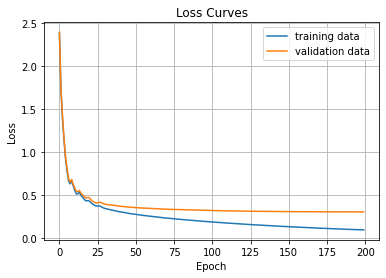

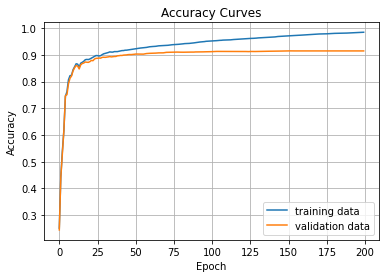

In [69]:
# --- MAIN --- #
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
X_train = trainData.reshape(trainData.shape[0], -1)
X_valid = validData.reshape(validData.shape[0], -1)
X_test = testData.reshape(testData.shape[0], -1)
Y_train, Y_valid, Y_test = convertOneHot(trainTarget, validTarget, testTarget)

training(X_train, Y_train, epochs=200, alpha=0.1, gamma=0.9, hidden_units=1000)